## Quantitative Analysis of Histopathological Images for Autoimmune Diseases Diagnosis

### Brief about the Autoimmune diseases

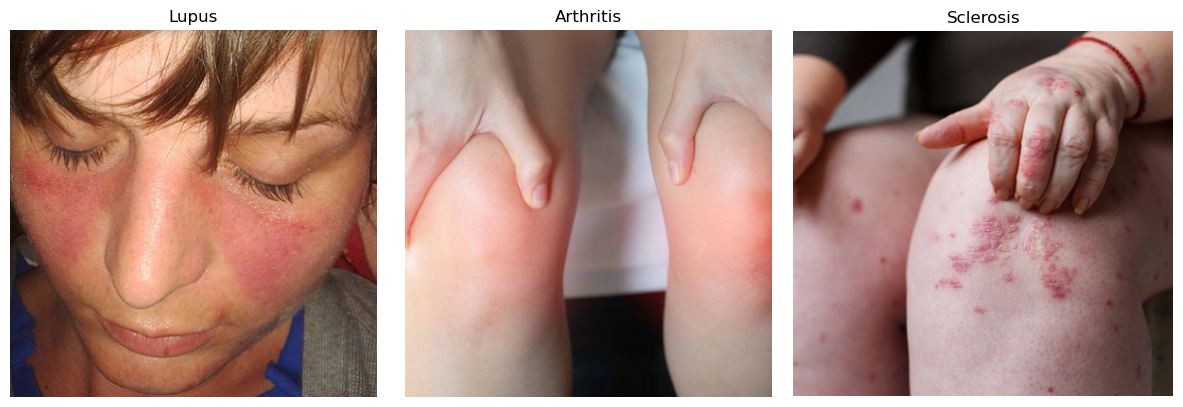

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_lupus = mpimg.imread('Medical/Disease Images/Lupus.png')
img_arthritis = mpimg.imread('Medical/Disease Images/Arthritis.png')
img_sclerosis = mpimg.imread('Medical/Disease Images/Sclerosis.png')

# Create a figure with a single row and three columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display each image
axs[0].imshow(img_lupus)
axs[0].set_title('Lupus')
axs[0].axis('off')

axs[1].imshow(img_arthritis)
axs[1].set_title('Arthritis')
axs[1].axis('off')

axs[2].imshow(img_sclerosis)
axs[2].set_title('Sclerosis')
axs[2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Data Collection

In [3]:
# Data directories
data_dir = 'Medical'
subdirectories = ['Lupus', 'Arthritis', 'Sclerosis']

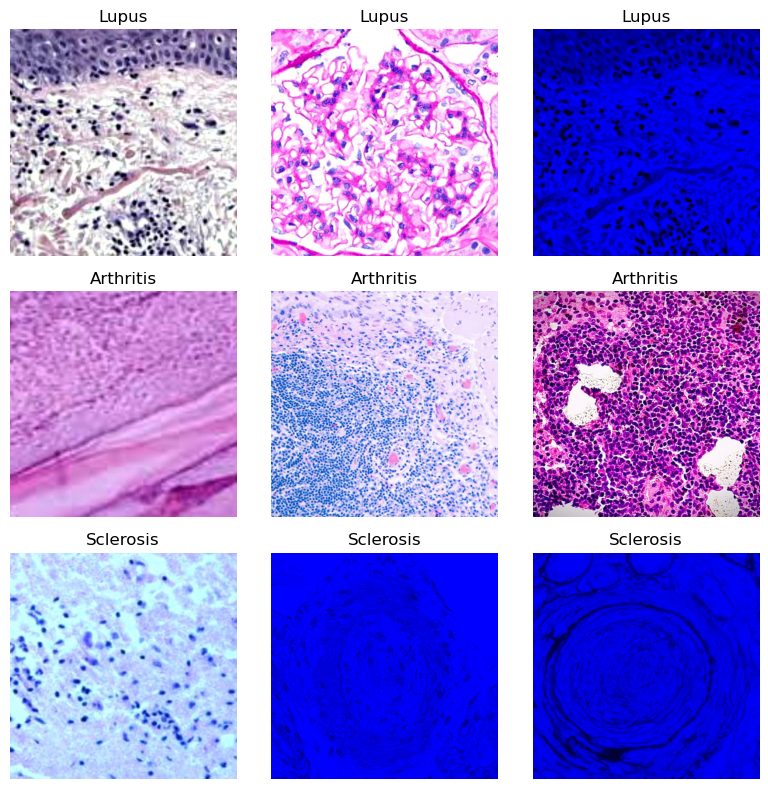

In [4]:
fig, axs = plt.subplots(len(subdirectories), 3, figsize=(8, 8))

for i, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(data_dir, subdir)
    for j in range(3):
        filename = os.listdir(subdir_path)[j]
        img_path = os.path.join(subdir_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].set_title(subdir)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing

In [5]:
cleaned_images = []

for subdir in subdirectories:
    subdir_path = os.path.join(data_dir, subdir)
    for filename in os.listdir(subdir_path):
        img_path = os.path.join(subdir_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Apply Gaussian blur for noise removal
            cleaned_img = cv2.GaussianBlur(img, (5, 5), 0)
            cleaned_images.append((cleaned_img, subdir))
        else:
            print(f"Could not read image: {img_path}")


In [6]:
# Preprocessing Function
def preprocess_image(img):
    # Resize the image to a desired size (e.g., 224x224)
    resized_img = cv2.resize(img, (224, 224))
    return resized_img

In [7]:
# Apply Preprocessing to Cleaned Images
preprocessed_images = []
labels = []

In [8]:
for img, label in cleaned_images:
    preprocessed_img = preprocess_image(img)
    preprocessed_images.append(preprocessed_img)
    labels.append(label)

### Data Visualization

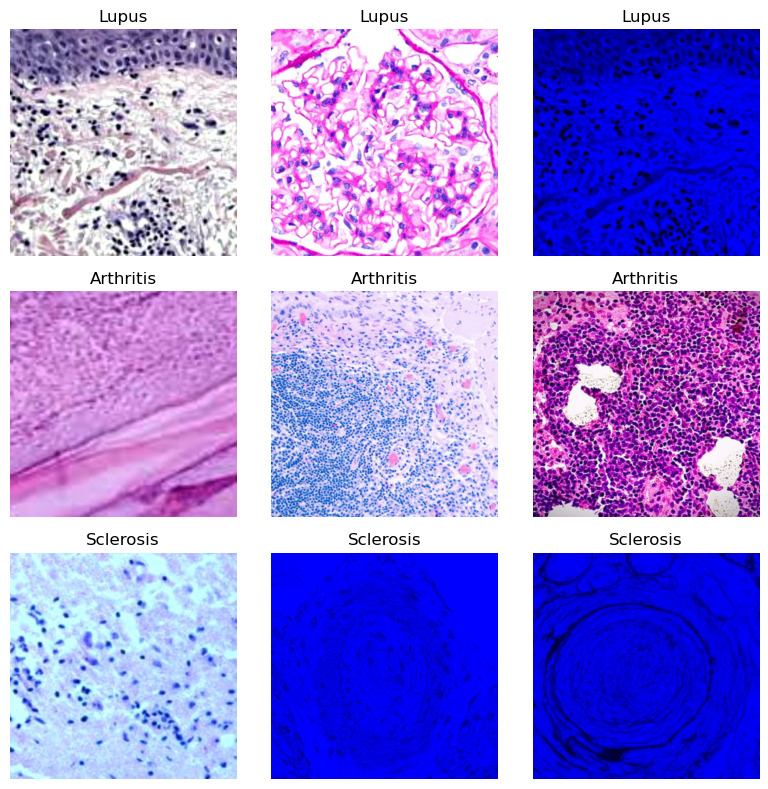

In [9]:
# Display preprocessed images after Gaussian blur
fig, axs = plt.subplots(len(subdirectories), 3, figsize=(8, 8))

for i, subdir in enumerate(subdirectories):
    subdir_preprocessed_images = [img for img, label in cleaned_images if label == subdir]
    for j in range(3):
        img = subdir_preprocessed_images[j]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with matplotlib
        axs[i, j].imshow(img)
        axs[i, j].set_title(subdir)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Convert lists to numpy arrays
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)

In [11]:
# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [12]:
# Convert encoded labels to categorical (one-hot encoding)
categorical_labels = to_categorical(encoded_labels)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, categorical_labels, test_size=0.2, random_state=42)

In [14]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

In [15]:
# Apply data augmentation only to training data
train_generator = datagen.flow(X_train, y_train, batch_size=32)

### Model Evaluation

In [17]:
# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Extract features for each preprocessed image using VGG16
def extract_features(data, model):
    features = model.predict(data)
    return features

In [19]:
# Extract features for training and testing data
train_features = []
for img in X_train:
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
    img = preprocess_input(img)  # Preprocess the image for VGG16
    feature = extract_features(img, base_model)
    train_features.append(feature.flatten())

1/1 [==============================] - 0s 121ms/step


In [20]:
test_features = []
for img in X_test:
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input
    img = preprocess_input(img)  # Preprocess the image for VGG16
    feature = extract_features(img, base_model)
    test_features.append(feature.flatten())

1/1 [==============================] - 0s 138ms/step


In [21]:
# Convert lists to numpy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)

In [22]:
# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(subdirectories), activation='softmax')  # Output layer with number of classes
])

In [23]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 12977667 (49.51 MB)
Trainable params: 12977667 (49.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Fit the model
history = model.fit(
    train_features, y_train,
    epochs=20,
    batch_size=30,
    validation_data=(test_features, y_test)
)

Epoch 1/20


4/4 [==============================] - 2s 208ms/step - loss: 10.7744 - accuracy: 0.4158 - val_loss: 1.1427 - val_accuracy: 0.7308
Epoch 2/20
4/4 [==============================] - 1s 139ms/step - loss: 3.7946 - accuracy: 0.6535 - val_loss: 0.1382 - val_accuracy: 0.9615
Epoch 3/20
4/4 [==============================] - 1s 141ms/step - loss: 3.1719 - accuracy: 0.7426 - val_loss: 0.0805 - val_accuracy: 0.9615
Epoch 4/20
4/4 [==============================] - 1s 142ms/step - loss: 1.2455 - accuracy: 0.8119 - val_loss: 0.0381 - val_accuracy: 0.9615
Epoch 5/20
4/4 [==============================] - 1s 135ms/step - loss: 1.0193 - accuracy: 0.8713 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 134ms/step - loss: 1.3641 - accuracy: 0.8812 - val_loss: 8.7064e-04 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 132ms/step - loss: 1.2144 - accuracy: 0.8911 - val_loss: 7.6326e-05 - val_accuracy: 1.0000
Epoch 8/2

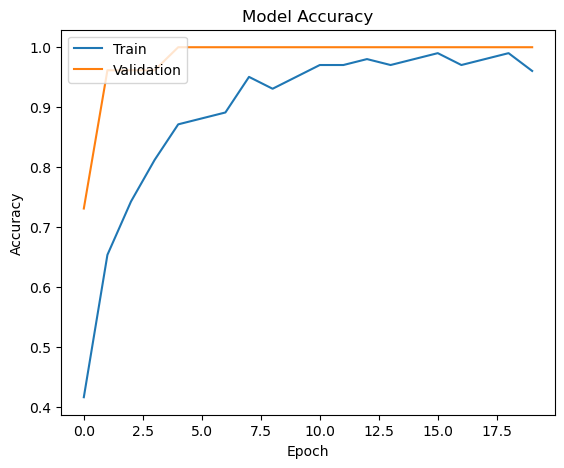

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

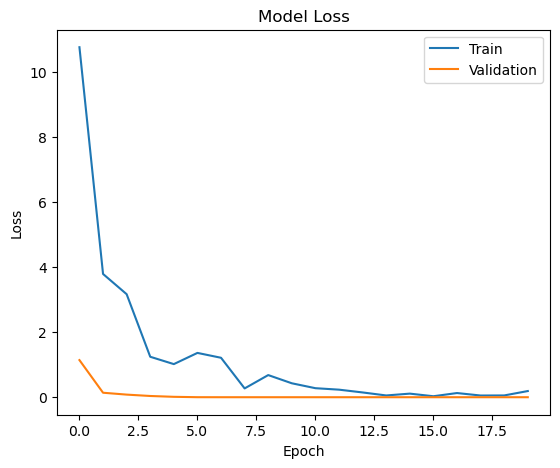

In [27]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
# Classification report and confusion matrix
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=subdirectories))

1/1 [==============================] - 0s 78ms/step
              precision    recall  f1-score   support

       Lupus       1.00      1.00      1.00         7
   Arthritis       1.00      1.00      1.00        10
   Sclerosis       1.00      1.00      1.00         9

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



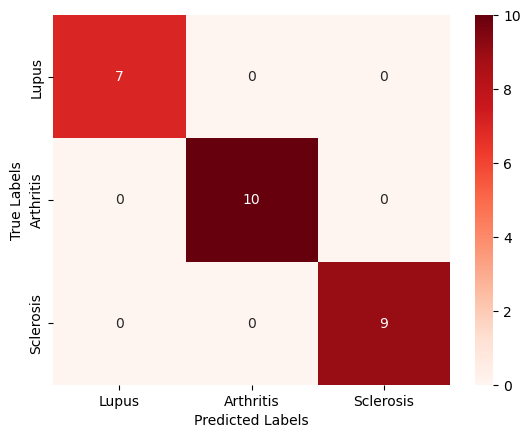

In [29]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, xticklabels=subdirectories, yticklabels=subdirectories, cmap="Reds")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Analysis Using Patterns

In [30]:
# Function to identify patterns
def identify_patterns(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Threshold the image
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours on the original image
    pattern_img = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    return pattern_img

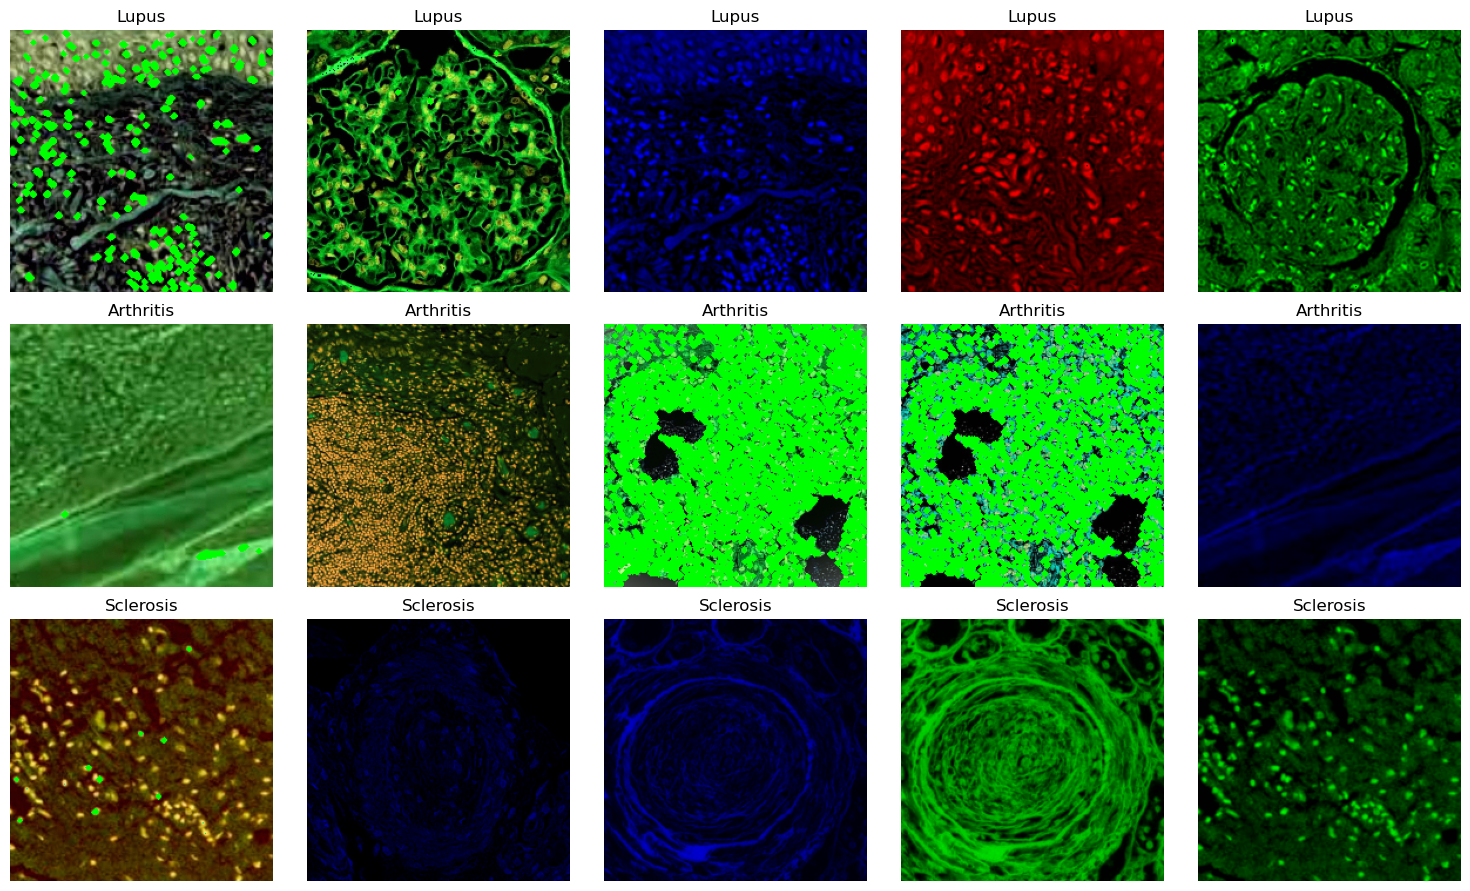

In [32]:
# Function to display identified patterns
num_images_per_directory = 5 
# Calculate number of rows and columns for subplots
num_rows = len(subdirectories)
num_cols = num_images_per_directory

fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

for i, subdir in enumerate(subdirectories):
    subdir_images = preprocessed_images[labels == subdir][:num_images_per_directory]
    for j in range(num_images_per_directory):
        img = subdir_images[j]
        pattern_img = identify_patterns(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        axs[i, j].imshow(pattern_img, cmap='gray')  # Display pattern image in grayscale
        axs[i, j].set_title(f'{subdir}')
        axs[i, j].axis('off')

# Hide empty subplots (not necessary since we ensure the number of images matches the subplots)
for i in range(num_rows):
    for j in range(num_images_per_directory, num_cols):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Load the base ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [34]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(subdirectories), activation='softmax')(x)

### Model Evaluation

In [35]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [37]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 35s 3s/step - loss: 1.5559 - accuracy: 0.3465 - val_loss: 1.0340 - val_accuracy: 0.4615
Epoch 2/10
6/6 [==============================] - 15s 2s/step - loss: 1.0155 - accuracy: 0.5743 - val_loss: 0.9058 - val_accuracy: 0.6154
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 0.5106 - accuracy: 0.8218 - val_loss: 0.8206 - val_accuracy: 0.7308
Epoch 4/10
6/6 [==============================] - 14s 2s/step - loss: 0.4620 - accuracy: 0.8020 - val_loss: 0.7433 - val_accuracy: 0.6923
Epoch 5/10
6/6 [==============================] - 13s 2s/step - loss: 0.3201 - accuracy: 0.9208 - val_loss: 0.6899 - val_accuracy: 0.6923
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 0.2311 - accuracy: 0.9406 - val_loss: 0.6339 - val_accuracy: 0.7692
Epoch 7/10
6/6 [==============================] - 21s 3s/step - loss: 0.3107 - accuracy: 0.9109 - val_loss: 0.6055 - val_accuracy: 0.8077
Epoch 8/10
6/6 [==================

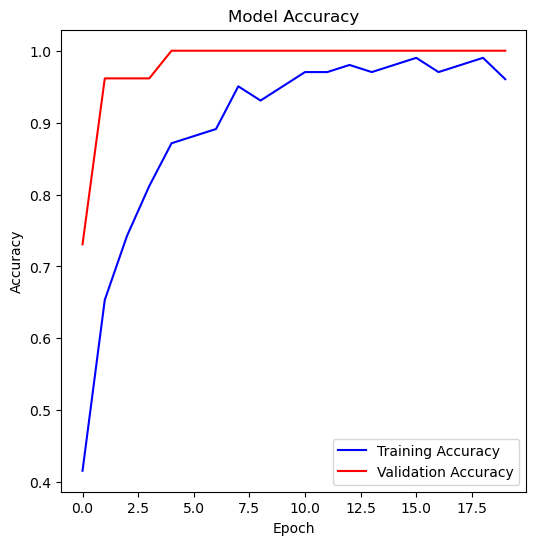

In [43]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

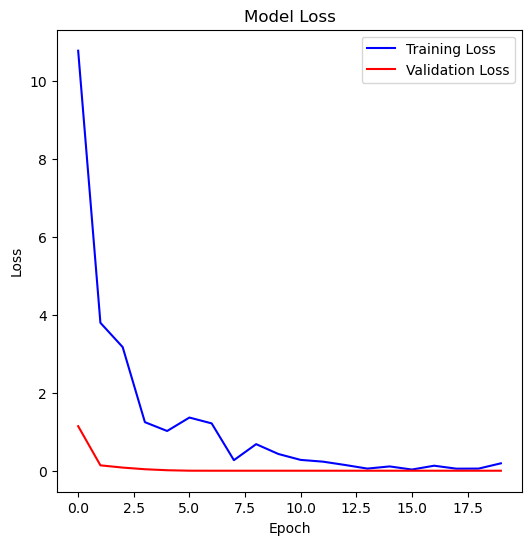

In [44]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Prepare to identify correct predictions
correct_images_per_dir = {subdir: [] for subdir in subdirectories}

In [46]:
# Predict and identify correct images
for subdir in subdirectories:
    subdir_images = [img for img, label in zip(preprocessed_images, labels) if label == subdir][:50]
    
    if len(subdir_images) == 0:
        continue

    subdir_images = np.array(subdir_images)
    predictions = model.predict(subdir_images)
    
    for img, prediction in zip(subdir_images, predictions):
        predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
        if predicted_label == subdir:
            correct_images_per_dir[subdir].append(img)
        if len(correct_images_per_dir[subdir]) >= 5:
            break

2/2 [==============================] - 2s 391ms/step


### Final Results

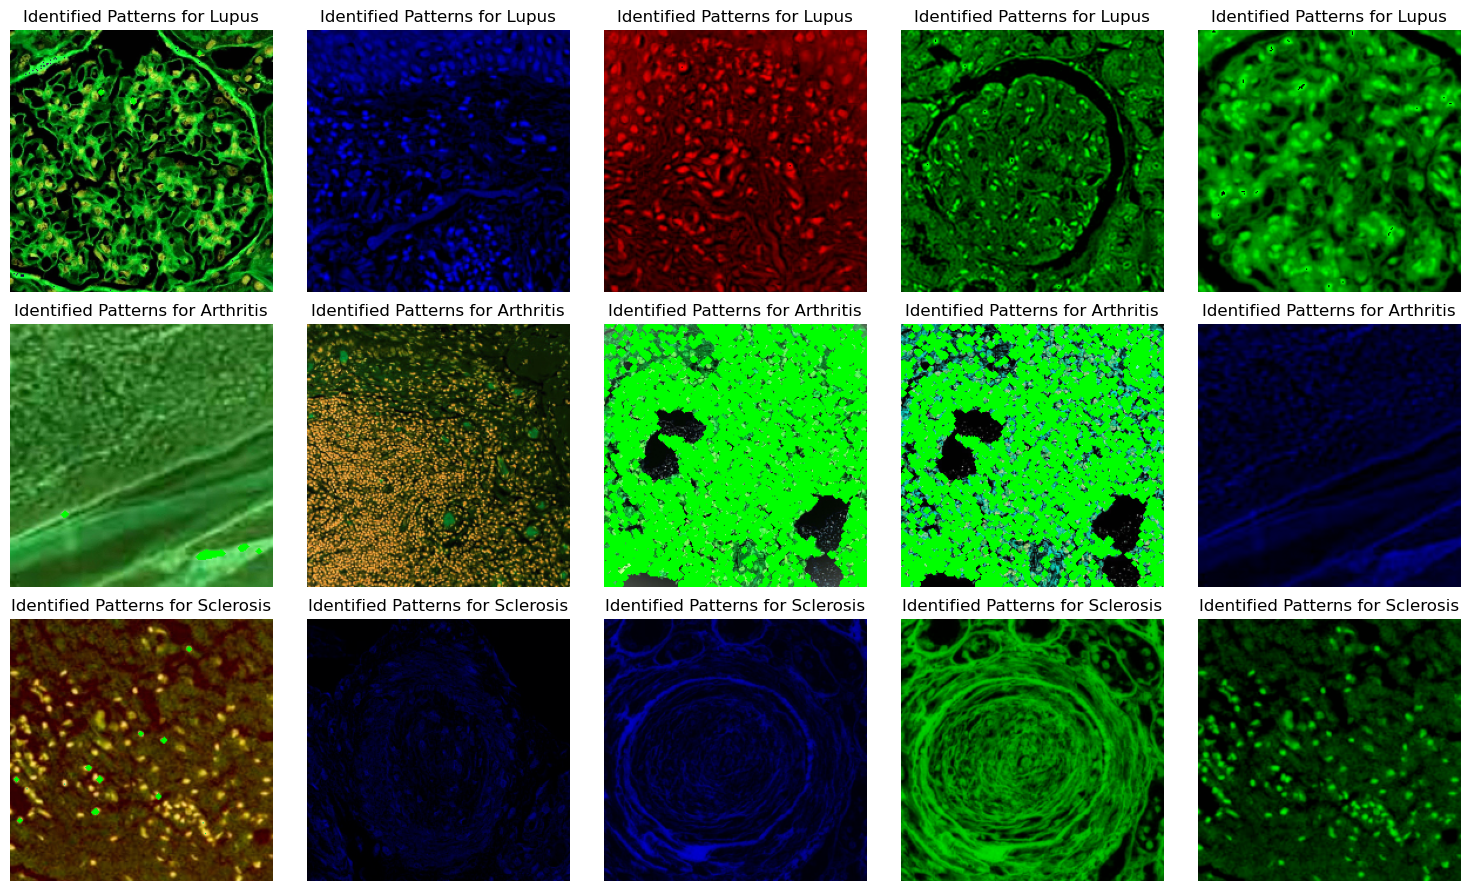

In [47]:
# Display the first 5 correctly identified images with patterns from each directory
num_images_per_directory = 5

fig, axs = plt.subplots(len(subdirectories), num_images_per_directory, figsize=(3 * num_images_per_directory, 3 * len(subdirectories)))

for i, subdir in enumerate(subdirectories):
    for j, img in enumerate(correct_images_per_dir[subdir]):
        pattern_img = identify_patterns(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        
        axs[i, j].imshow(pattern_img, cmap='gray')  # Display pattern image in grayscale
        axs[i, j].set_title(f'Identified Patterns for {subdir}')
        axs[i, j].axis('off')

    # Hide empty subplots
    for j in range(len(correct_images_per_dir[subdir]), num_images_per_directory):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()